In [ ]:
from sentence_transformers import SentenceTransformer
bmodel = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
import os
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk import FreqDist
import text2emotion as te
from LeXmo import LeXmo
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('data/data.csv')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
bow = count_vect.fit_transform(df['SpeechNormalize'].values)
bow.shape

In [ ]:
terms = count_vect.get_feature_names()

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


In [1]:
distorsions = []
for k in range(2, 20):
    model = KMeans(n_clusters = k)
    model.fit(bow)
    distorsions.append(model.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

NameError: name 'KMeans' is not defined

In [1]:
model = KMeans(n_clusters = 4,init='k-means++',random_state=99)
model.fit(bow)

NameError: name 'KMeans' is not defined

In [ ]:
labels = model.labels_
cluster_center=model.cluster_centers_

In [ ]:
labels

In [ ]:
cluster_center

In [ ]:
# which tells us that clusters are far away from each other
from sklearn import metrics
silhouette_score = metrics.silhouette_score(bow, labels, metric='euclidean')
silhouette_score

In [ ]:
# Giving Labels/assigning a cluster to each point/text 
df['Label'] = model.labels_ # the last column you can see the label numebers
df.head(10)

In [ ]:
# How many points belong to each cluster -> using group by in pandas
df.groupby(['Label'])['SpeechNormalize'].count()

In [ ]:
#to find the top 10 features of cluster centriod
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = count_vect.get_feature_names()
for i in range(4):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
        print()

In [ ]:
# visually how points or reviews are distributed across 10 clusters 
import matplotlib.pyplot as plt
plt.bar([x for x in range(4)], df.groupby(['Label'])['SpeechNormalize'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [16]:
from wordcloud import WordCloud
def getClusterAnalysis(i):
    
    
# Create a WordCloud object
    wordcloud = WordCloud(width=800, height=500, max_font_size=110, background_color="white", max_words=3000, contour_width=3, contour_color='steelblue')

    all_words = ''.join([word for word in df[df['Label'] == i]['SpeechNormalize']]).replace('\n', '.')

    # Generate a word cloud
    wordcloud.generate(all_words)
    print('Total speechs ',df[df['Label'] == i]['SpeechNormalize'].shape[0])
    # Visualize the word cloud
    return wordcloud.to_image()

Total speechs  36


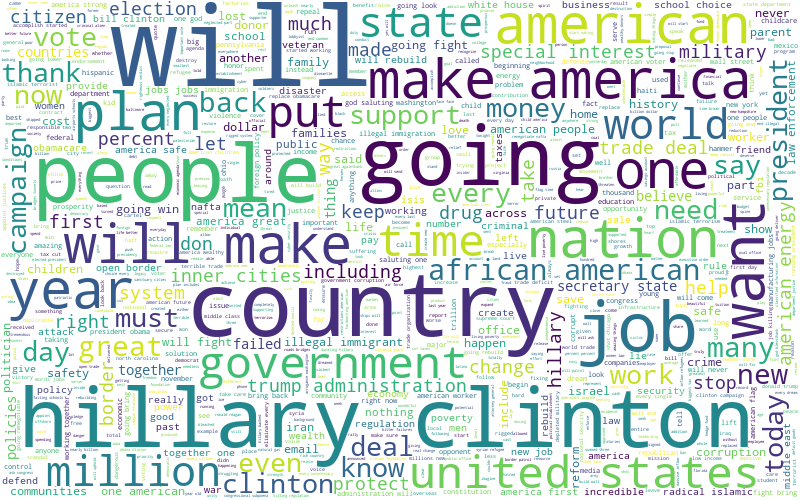

In [17]:
getClusterAnalysis(0)

Total speechs  6


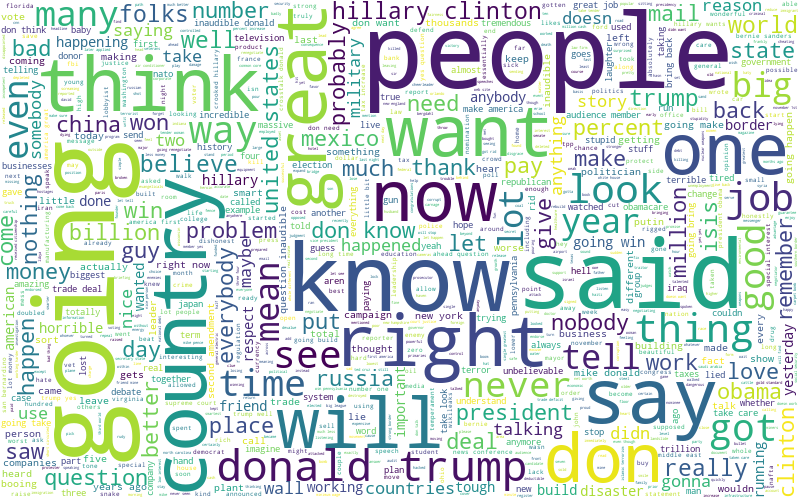

In [18]:
getClusterAnalysis(1)

Total speechs  14


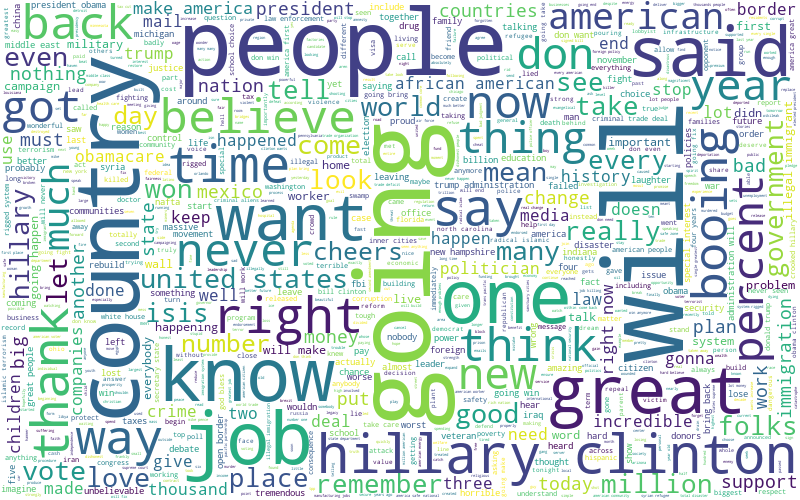

In [19]:
getClusterAnalysis(2)

Total speechs  18


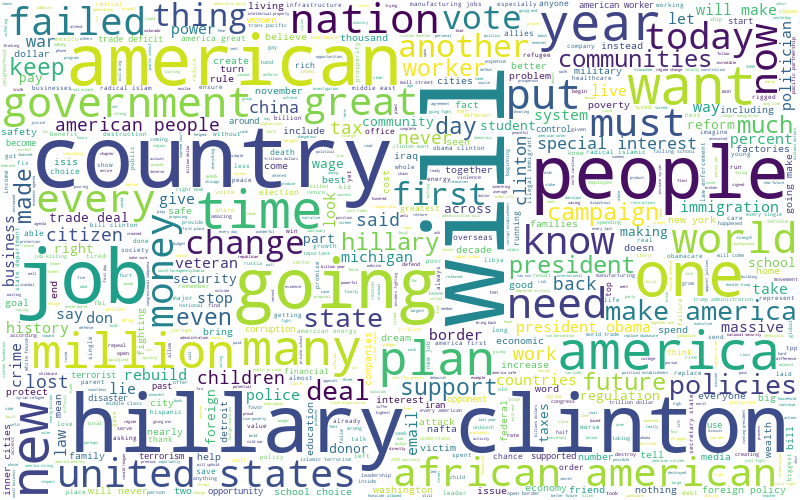

In [20]:
getClusterAnalysis(3)

## TEXT RANK on Clusters 

To get top ranked relevant sentences in the cluster for in-depth cluster analysis.

In [ ]:
import numpy as np
from tqdm import tqdm
import networkx
import matplotlib.pyplot as plt
%matplotlib inline

def textRank(cluster):
    all_words = ''.join([word for word in df[df['Label'] == cluster]['SpeechNormalize']]).replace('\n', '.')
    df_analysis = pd.DataFrame(all_words.split('.'), columns=['Speech'])
    df_analysis = df_analysis.loc[df_analysis['Speech'].str.split(' ').apply(len) > 8]
    df_analysis.reset_index(inplace=True)
    bert_embeddings = bmodel.encode(df_analysis['Speech'])
    a = bert_embeddings[0]
    b = bert_embeddings[1]
    cos_sim = (a @ b.T) / (np.linalg.norm(a)*np.linalg.norm(b))
    
    M = np.eye(7800)

    for i,a in tqdm(enumerate(bert_embeddings)):
        for j,b in enumerate(bert_embeddings):
            if i != j:
                M[i,j] = (a @ b.T) / (np.linalg.norm(a)*np.linalg.norm(b))
                
    similarity_graph = networkx.from_numpy_array(M)
    return similarity_graph


In [ ]:
similarity_graph = textRank(0)
plt.figure(figsize=(1200, 800))
networkx.draw_networkx(similarity_graph, node_color='blue')

scores=networkx.pagerank(similarity_graph)
nx_ranked_sentences = sorted(((score, index) for index, score 
                                            in scores.items()),reverse=True)